#  biogeme.models 

## Examples of use

This webpage is for programmers who need examples of use of the functions of the module. The examples are designed to illustrate the syntax. They do not correspond to any meaningful model. For examples of models, visit  [biogeme.epfl.ch](http://biogeme.epfl.ch).

In [1]:
import datetime
print(datetime.datetime.now())

2023-08-04 18:40:47.004554


In [2]:
import biogeme.version as ver
print(ver.getText())

biogeme 3.2.12 [2023-08-04]
Home page: http://biogeme.epfl.ch
Submit questions to https://groups.google.com/d/forum/biogeme
Michel Bierlaire, Transport and Mobility Laboratory, Ecole Polytechnique Fédérale de Lausanne (EPFL)



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import biogeme.database as db
import biogeme.models as models
from biogeme.expressions import Variable, Beta

## Definition of a database

In [5]:
df = pd.DataFrame({'Person': [1, 1, 1, 2, 2],
                   'Exclude': [0, 0, 1, 0, 1],
                   'Variable1': [1, 2, 3, 4, 5],
                   'Variable2': [10, 20, 30, 40, 50],
                   'Choice': [1, 2, 3, 1, 2],
                   'Av1': [0, 1, 1, 1, 1],
                   'Av2': [1, 1, 0, 1, 1],
                   'Av3': [0, 1, 1, 1, 0]})
myData = db.Database('test', df)

## Piecewise linear specification

A piecewise linear specification (sometimes called 'spline') is a continuous but not differentiable function of the variable. It is defined based on thresholds. Between two thresholds, the function is linear. And the slope is changing after each threshold.
Consider a variable $t$ and an interval $[a,a+b]$. We define a new variable 
$$
x_{[a,b]}(t) = \max(0,\min(t-a,b)) =
\left\{
  \begin{array}{ll}
 0 & \text{if } t < a, \\
 t-a & \text{if } a \leq t < a+b, \\
 b  & \text{otherwise}.
  \end{array}
\right.
$$
For each interval $]-\infty,a]$, we have
$$
x_{]-\infty,a]}(t) = \min(t,a) = \left\{
  \begin{array}{ll}
 t & \text{if } t < a, \\
 a  & \text{otherwise}.
  \end{array}
\right..
$$
For each interval $[a,+\infty[$, we have
$$
x_{]-\infty,a]}(t) = \max(0,t-a) = \left\{
  \begin{array}{ll}
 0& \text{if } t < a, \\
 t-a  & \text{otherwise}.
  \end{array}
\right..
$$
If we consider a series of threshold $$\alpha_1 < \alpha_2 < \ldots <\alpha_K,$$ the piecewise linear transform of variable $t$ is 
$$ \sum_{k=1}^{K-1} \beta_k x_{[\alpha_k,\alpha_{k+1}]},$$
where $\beta_k$ is the slope of the linear function in interval $[\alpha_k,\alpha_{k+1}]$.
 

The next statement generates the variables, given the thresholds. A 'None' is equivalent to $\infty$, and can only appear first (and it means $-\infty$) or last (and it means $+\infty$).

In [6]:
x = Variable('x')
thresholds = [None, 90, 180, 270, None]
variables = models.piecewiseVariables(x, thresholds)
print(variables)

[bioMin(x, `90.0`), bioMax(`0.0`, bioMin((x - `90.0`), `90.0`)), bioMax(`0.0`, bioMin((x - `180.0`), `90.0`)), bioMax(`0.0`, (x - `270.0`))]


The next statement automatically generates the formula, including the Beta parameters, that are initialized to zero. 

In [7]:
formula = models.piecewiseFormula('x', thresholds)
print(formula)

bioMultSum((beta_x_minus_inf_90(init=0) * bioMin(x, `90.0`)), (beta_x_90_180(init=0) * bioMax(`0.0`, bioMin((x - `90.0`), `90.0`))), (beta_x_180_270(init=0) * bioMax(`0.0`, bioMin((x - `180.0`), `90.0`))), (beta_x_270_inf(init=0) * bioMax(`0.0`, (x - `270.0`))))


It is also possible to initialize the Beta parameters with other values. Note also that the first argument can be either the name of the variable (as in the previous call) or the variable itself.

In [8]:
betas = [-0.016806308, -0.010491137, -0.002012234, -0.020051303]
formula = models.piecewiseFormula(x, thresholds, betas)
print(formula)

bioMultSum((`-0.016806308` * bioMin(x, `90.0`)), (`-0.010491137` * bioMax(`0.0`, bioMin((x - `90.0`), `90.0`))), (`-0.002012234` * bioMax(`0.0`, bioMin((x - `180.0`), `90.0`))), (`-0.020051303` * bioMax(`0.0`, (x - `270.0`))))


We provide a plot of a piecewise linear specification.

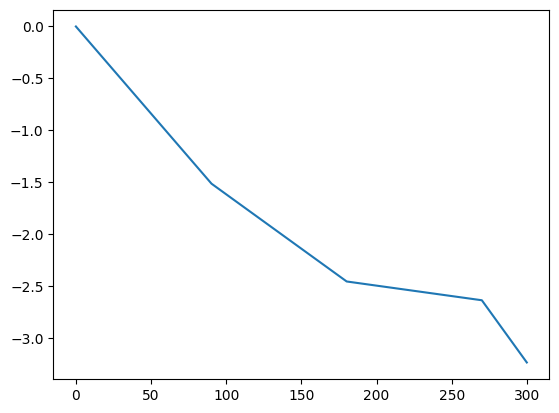

In [9]:
X = np.arange(0, 300, 0.1)
Y = [models.piecewiseFunction(x,
                              thresholds,[-0.016806308,
                                          -0.010491137,
                                          -0.002012234,
                                          -0.020051303]) 
     for x in X]
plt.plot(X,Y)

## Logit

In [10]:
V = {1: Variable('Variable1'), 2: 0.1, 3: -0.1} 
av = {1: Variable('Av1'), 
      2: Variable('Av2'), 
      3: Variable('Av3')}

Calculation of the (log of the) logit for the three alternatives, based on their availability.

Alternative 1

In [11]:
p1 = models.logit(V, av, 1)
p1.getValue_c(myData, prepareIds=True)

The chosen alternative [`1.0`] is not available for the following observations (rownumber[choice]): 0[1.0]


array([0.        , 0.78614804, 0.95689275, 0.9644926 , 0.99260846])

In [12]:
p1 = models.loglogit(V, av, 1)
p1.getValue_c(myData, prepareIds=True)

The chosen alternative [`1.0`] is not available for the following observations (rownumber[choice]): 0[1.0]


array([-1.79769313e+308, -2.40610156e-001, -4.40639679e-002,
       -3.61531156e-002, -7.41899416e-003])

Alternative 2

In [13]:
p2 = models.logit(V, av, 2)
p2.getValue_c(myData, prepareIds=True)

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 2[2.0]


array([1.        , 0.11758308, 0.        , 0.01952317, 0.00739154])

In [14]:
p2 = models.loglogit(V, av, 2)
p2.getValue_c(myData, prepareIds=True)

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 2[2.0]


array([ 0.00000000e+000, -2.14061015e+000, -1.79769313e+308,
       -3.93615311e+000, -4.90741899e+000])

Alternative 3

In [15]:
p3 = models.logit(V,av,3)
p3.getValue_c(myData, prepareIds=True)

The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-4[3.0]


array([0.        , 0.09626888, 0.04310725, 0.01598422, 0.        ])

In [16]:
p3 = models.loglogit(V,av,3)
p3.getValue_c(myData, prepareIds=True)

The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-4[3.0]


array([-1.79769313e+308, -2.34061016e+000, -3.14406397e+000,
       -4.13615312e+000, -1.79769313e+308])

Calculation of the log of the logit for the three alternatives, **assuming that they are all available**.

Alternative 1

In [17]:
pa1 = models.logit(V, av=None, i=1)
pa1.getValue_c(myData, prepareIds=True)

array([0.57489742, 0.78614804, 0.90903106, 0.9644926 , 0.98663764])

In [18]:
pa1 = models.loglogit(V, av=None, i=1)
pa1.getValue_c(myData, prepareIds=True)

array([-0.55356365, -0.24061016, -0.09537602, -0.03615312, -0.01345244])

Alternative 2

In [19]:
pa2 = models.logit(V, av=None, i=2)
pa2.getValue_c(myData, prepareIds=True)

array([0.23373585, 0.11758308, 0.05001782, 0.01952317, 0.00734708])

In [20]:
pa2 = models.loglogit(V,av=None,i=2)
pa2.getValue_c(myData, prepareIds=True)

array([-1.45356365, -2.14061015, -2.99537601, -3.93615311, -4.91345244])

Alternative 3

In [21]:
pa3 = models.logit(V, av=None, i=3)
pa3.getValue_c(myData, prepareIds=True)

array([0.19136673, 0.09626888, 0.04095112, 0.01598422, 0.00601528])

In [22]:
pa3 = models.loglogit(V, av=None, i=3)
pa3.getValue_c(myData, prepareIds=True)

array([-1.65356365, -2.34061016, -3.19537602, -4.13615312, -5.11345244])

## Boxcox transform

The Box-Cox transform of a variable $x$ is defined as $$B(x,\ell) = \frac{x^{\ell}-1}{\ell},$$ where $\ell$ is a parameter that can be estimated from data.  It has the property that $$\lim_{\ell \to 0} B(x,\ell)=\log(x).$$

In [23]:
x = Variable('Variable1')
models.boxcox(x, 4)

{{0:{{0:(((Variable1 ** `4.0`) - `1.0`) / `4.0`), 1:(((log(Variable1) + (`4.0` * (log(Variable1) ** `2.0`))) + ((`16.0` * (log(Variable1) ** `3.0`)) / `6.0`)) + ((`64.0` * (log(Variable1) ** `4.0`)) / `24.0`))}[((`1e-05` > `4.0`) * ((-`1e-05`) < `4.0`))], 1:`0.0`}[(Variable1 == `0.0`)]

In [24]:
x = Variable('Variable1')
models.boxcox(x, 0)

{{0:{{0:(((Variable1 ** `0.0`) - `1.0`) / `0.0`), 1:(((log(Variable1) + (`0.0` * (log(Variable1) ** `2.0`))) + ((`0.0` * (log(Variable1) ** `3.0`)) / `6.0`)) + ((`0.0` * (log(Variable1) ** `4.0`)) / `24.0`))}[((`1e-05` > `0.0`) * ((-`1e-05`) < `0.0`))], 1:`0.0`}[(Variable1 == `0.0`)]

In [25]:
l = Variable('Variable2')
e = models.boxcox(x, l)
print(e)

{{0:{{0:(((Variable1 ** Variable2) - `1.0`) / Variable2), 1:(((log(Variable1) + (Variable2 * (log(Variable1) ** `2.0`))) + (((Variable2 ** `2.0`) * (log(Variable1) ** `3.0`)) / `6.0`)) + (((Variable2 ** `3.0`) * (log(Variable1) ** `4.0`)) / `24.0`))}[((Variable2 < `1e-05`) * (Variable2 > (-`1e-05`)))], 1:`0.0`}[(Variable1 == `0.0`)]


In [26]:
e.getValue_c(myData, prepareIds=True)

array([0.00000000e+00, 5.24287500e+04, 6.86303774e+12, 3.02231455e+22,
       1.77635684e+33])

We numerically illustrate  that, when $\lambda$ goes to 0, the BoxCox transform of $x$ converges to the log of $x$.

In [27]:
for ell in range(1, 16):
    x = 3
    bc = models.boxcox(x, 10**-ell).getValue()
    print(f'ell=l0^(-{ell}): {bc:.6g} - {np.log(x):.6g} = {bc - np.log(x):.6g}')


ell=l0^(-1): 1.16123 - 1.09861 = 0.0626195
ell=l0^(-2): 1.10467 - 1.09861 = 0.00605691
ell=l0^(-3): 1.09922 - 1.09861 = 0.000603696
ell=l0^(-4): 1.09867 - 1.09861 = 6.03497e-05
ell=l0^(-5): 1.09862 - 1.09861 = 6.03476e-06
ell=l0^(-6): 1.09861 - 1.09861 = 1.20695e-06
ell=l0^(-7): 1.09861 - 1.09861 = 1.20695e-07
ell=l0^(-8): 1.09861 - 1.09861 = 1.20695e-08
ell=l0^(-9): 1.09861 - 1.09861 = 1.20695e-09
ell=l0^(-10): 1.09861 - 1.09861 = 1.20695e-10
ell=l0^(-11): 1.09861 - 1.09861 = 1.20695e-11
ell=l0^(-12): 1.09861 - 1.09861 = 1.20703e-12
ell=l0^(-13): 1.09861 - 1.09861 = 1.20792e-13
ell=l0^(-14): 1.09861 - 1.09861 = 1.19904e-14
ell=l0^(-15): 1.09861 - 1.09861 = 1.11022e-15


## MEV models

MEV models are defined as $$\frac{e^{V_i + \ln G_i(e^{V_1},\ldots,e^{V_J})}}{\sum_j e^{V_j + \ln G_j(e^{V_1},\ldots,e^{V_J})}},$$ where $G$ is a generating function, and
 $$G_i=\frac{\partial G}{\partial y_i}(e^{V_1},\ldots,e^{V_J})$$

### Nested logit model

The $G$ function for the nested logit model is defined such that $$G_i=\frac{\partial G}{\partial y_i}(e^{V_1},\ldots,e^{V_J}) = \mu e^{(\mu_m-1)V_i} \left(\sum_{i=1}^{J_m} e^{\mu_m V_i}\right)^{\frac{\mu}{\mu_m}-1},$$ where the choice set is partitioned into $J_m$ nests, each associated with a parameter $\mu_m$, and $\mu$ is the scale parameter. The condition is $0 \leq \mu \leq \mu_m$ must be verified. In general, $\mu$ is normalized to 1.0.   

This is an example with 5 alternatives. Nest A contains alternatives 1, 2 and 4, and is associated with a scale parameter $\mu_A=1.2$. Nest B contains alternatives 3 and 5, and is associated with a scale parameter $\mu_B=2.3$. 

In [28]:
V = {1: Variable('Variable1'), 2: 0.1, 3: -0.1, 4: -0.2, 5: 0.2}
av = {1: 1, 2: 0, 3: 1, 4: 1, 5: 1}
nestA = 1.2, [1, 2, 4]
nestB = 2.3, [3, 5]

In [29]:
p1 = models.nested(V,
                   availability=av, 
                   nests=(nestA, nestB),
                   choice=1)
p1.getValue_c(myData, prepareIds=True)

array([0.55789028, 0.78684631, 0.9138115 , 0.96786857, 0.98836318])

If all the alternatives are available, define the availability dictionary as None.

In [30]:
p1 = models.nested(V,
                   availability=None,
                   nests=(nestA, nestB),
                   choice=1)
p1.getValue_c(myData, prepareIds=True)

array([0.46404047, 0.72661956, 0.88850463, 0.959216  , 0.98563615])

The syntax is similar to obtain the log of the probability. 

In [31]:
p2 = models.lognested(V,
                      availability=av,
                      nests=(nestA, nestB),
                      choice=1)
p2.getValue_c(myData, prepareIds=True)

array([-0.58359297, -0.23972234, -0.09013096, -0.03265898, -0.01170506])

In [32]:
p2 = models.lognested(V,
                      availability=None,
                      nests=(nestA, nestB),
                      choice=1)
p2.getValue_c(myData, prepareIds=True)

array([-0.7677835 , -0.31935224, -0.11821542, -0.041639  , -0.01446801])

If the value of the parameter $\mu$ is not 1, there is another function to call. Note that, for the sake of computational efficiency, it is not verified by the code if the condition $$0 \leq \mu \leq \mu_m$$ is valid.

In [33]:
p1 = models.nestedMevMu(V,
                        availability=av,
                        nests=(nestA, nestB),
                        choice=1,
                        mu=1.1)
p1.getValue_c(myData, prepareIds=True)

array([0.57151598, 0.80643395, 0.92814743, 0.9755475 , 0.9919295 ])

In [34]:
p1 = models.nestedMevMu(V,
                        availability=None,
                        nests=(nestA, nestB),
                        choice=1,
                        mu=1.1)
p1.getValue_c(myData, prepareIds=True)

array([0.47623579, 0.74427029, 0.90223305, 0.96678265, 0.98918584])

In [35]:
p1 = models.lognestedMevMu(V,
                           availability=av,
                           nests=(nestA, nestB),
                           choice=1,
                           mu=1.1)
p1.getValue_c(myData, prepareIds=True)

array([-0.55946283, -0.21513329, -0.07456469, -0.02475643, -0.00810324])

In [36]:
p1 = models.lognestedMevMu(V,
                           availability=None,
                           nests=(nestA, nestB),
                           choice=1,
                           mu=1.1)
p1.getValue_c(myData, prepareIds=True)

array([-0.74184219, -0.29535101, -0.10288243, -0.03378157, -0.01087306])

The validity of the nested structure can be verified.

In [37]:
isValid, msg = models.checkValidityNestedLogit(V, (nestA, nestB), alone=[])

In [38]:
isValid

True

In [39]:
print(msg)

The nested logit model is based on a partition. 


If one alternative does not belong to any nest...

In [40]:
nestA = 1.2, [1, 4]
nestB = 2.3, [3, 5]
isValid, msg = models.checkValidityNestedLogit(V, (nestA, nestB), alone=[])

In [41]:
isValid

False

In [42]:
print(msg)

Alternative(s) in the choice set, but not in any nest: {2}



If an alternative belongs to two nests

In [43]:
nestA = 1.2, [1, 2, 3, 4]
nestB = 2.3, [3, 5]
isValid, msg = models.checkValidityNestedLogit(V,(nestA,nestB), alone=[])

In [44]:
isValid

False

In [45]:
print(msg)

Two nests contain the following alternative(s): {3}
Two nests contain the following alternative(s): {3}



### Cross-nested logit model

The $G$ function for the cross nested logit model is defined such that $$G_i=\frac{\partial G}{\partial y_i}(e^{V_1},\ldots,e^{V_J}) = \mu  \sum_{m=1}^{M} \alpha_{im}^{\frac{\mu_m}{\mu}} e^{(\mu_m-1) V_i}\left( \sum_{j=1}^{J} \alpha_{jm}^{\frac{\mu_m}{\mu}} e^{\mu_m V_j} \right)^{\frac{\mu}{\mu_m}-1},$$
where each nest $m$ is associated with a parameter $\mu_m$ and, for each alternative $i$, a parameter $\alpha_{im} \geq 0$ that captures the degree of membership of alternative $i$ to nest $m$. $\mu$ is the scale parameter. For each alternative $i$, there must be at least one nest $m$ such that $\alpha_{im}>0$. The condition is $0 \leq \mu \leq \mu_m$ must be also verified. In general, $\mu$ is normalized to 1.0.   

This is an example with 5 alternatives and two nests.

- Alt. 1 belongs to nest A.
- Alt. 2 belongs to nest A.
- Alt. 3 belongs to both nest A (50%) and nest B (50%).
- Alt. 4 belongs to nest B.
- Alt. 5 belongs to nest B.

In [46]:
V = {1: Variable('Variable1'), 2: 0.1, 3: -0.1, 4: -0.2, 5: 0.2}
av = {1: 1, 2: 0, 3: 1, 4: 1, 5: 1}
alphaA = {1: 1, 2: 1, 3: 0.5, 4: 0, 5: 0}
alphaB = {1: 0, 2: 0, 3: 0.5, 4: 1, 5: 1}
nestA = 1.2, alphaA
nestB = 2.3, alphaB

In [47]:
p1 = models.cnl(V,
                availability=av,
                nests=(nestA, nestB),
                choice=1)
p1.getValue_c(myData, prepareIds=True)

array([0.60161076, 0.81080413, 0.92317655, 0.97098919, 0.98933903])

If all the alternatives are available, define the availability dictionary as None.

In [48]:
p1 = models.cnl(V,
                availability=None,
                nests=(nestA, nestB),
                choice=1)
p1.getValue_c(myData, prepareIds=True)

array([0.49345928, 0.74695583, 0.89735316, 0.96228089, 0.98660661])

If the value of the parameter $\mu$ is not 1, there is another function to call. Note that, for the sake of computational efficiency, it is not verified by the code if the condition $$0 \leq \mu \leq \mu_m$$ is verified.

In [49]:
p1 = models.cnlmu(V,
                  availability=av,
                  nests=(nestA, nestB),
                  choice=1,
                  mu=1.1)
p1.getValue_c(myData, prepareIds=True)

array([0.6110354 , 0.828654  , 0.93675704, 0.97837752, 0.99280536])

In [50]:
p1 = models.cnlmu(V,
                  availability=None,
                  nests=(nestA, nestB),
                  choice=1,
                  mu=1.1)
p1.getValue_c(myData, prepareIds=True)

array([0.50313974, 0.76313184, 0.91036491, 0.96956188, 0.99005685])

If the sample is endogenous, a correction must be included in the model, as proposed by [Bierlaire, Bolduc and McFadden (2008)](http://dx.doi.org/10.1016/j.trb.2007.09.003).
In this case, the generating function must first be defined, and the MEV model with correction is then called. 

In [51]:
logGi = models.getMevForCrossNested(V,
                                    availability=av,
                                    nests=(nestA, nestB))
logGi

{1: {{1:`0.0`, 0:log(bioMultSum(((`1.0` * exp((`0.19999999999999996` * Variable1))) * (bioMultSum((`1.0` * exp((`1.2` * Variable1))), (`0.0` * exp(`0.12`)), (`0.43527528164806206` * exp(`-0.12`)), (`0.0` * exp(`-0.24`)), (`0.0` * exp(`0.24`))) ** `-0.16666666666666663`)), ((`0.0` * exp((`1.2999999999999998` * Variable1))) * (bioMultSum((`0.0` * exp((`2.3` * Variable1))), (`0.0` * exp(`0.22999999999999998`)), (`0.2030630990890589` * exp(`-0.22999999999999998`)), (`1.0` * exp(`-0.45999999999999996`)), (`1.0` * exp(`0.45999999999999996`))) ** `-0.5652173913043478`))))}[(bioMultSum(((`1.0` * exp((`0.19999999999999996` * Variable1))) * (bioMultSum((`1.0` * exp((`1.2` * Variable1))), (`0.0` * exp(`0.12`)), (`0.43527528164806206` * exp(`-0.12`)), (`0.0` * exp(`-0.24`)), (`0.0` * exp(`0.24`))) ** `-0.16666666666666663`)), ((`0.0` * exp((`1.2999999999999998` * Variable1))) * (bioMultSum((`0.0` * exp((`2.3` * Variable1))), (`0.0` * exp(`0.22999999999999998`)), (`0.2030630990890589` * exp(`-0.229

In [52]:
correction = {1: -0.1, 2: 0.1, 3: 0.2, 4: -0.2, 5: 0}
p1 = models.mev_endogenousSampling(V, 
                                   logGi, 
                                   av, 
                                   correction, 
                                   choice=1) 
p1.getValue_c(myData, prepareIds=True)

array([0.57460722, 0.79415805, 0.91584339, 0.96822294, 0.98835331])

In [53]:
correction = {1: -0.1, 2: 0.1, 3: 0.2, 4: -0.2, 5: 0}
p1 = models.logmev_endogenousSampling(V,
                                      logGi,
                                      av,
                                      correction,
                                      choice=1) 
p1.getValue_c(myData, prepareIds=True)

array([-0.55406856, -0.23047278, -0.0879099 , -0.03229291, -0.01171504])

In [54]:
correction = {1: -0.1, 2: 0.1, 3: 0.2, 4: -0.2, 5: 0}
p1 = models.mev_endogenousSampling(V,
                                   logGi,
                                   av=None,
                                   correction=correction,
                                   choice=1) 
p1.getValue_c(myData, prepareIds=True)

array([0.46401513, 0.72247789, 0.8853334 , 0.95771369, 0.98503002])

In [55]:
correction = {1: -0.1, 2: 0.1, 3: 0.2, 4: -0.2, 5: 0}
p1 = models.logmev_endogenousSampling(V,
                                      logGi,
                                      av=None,
                                      correction=correction,
                                      choice=1) 
p1.getValue_c(myData, prepareIds=True)

array([-0.76783812, -0.32506846, -0.12179099, -0.04320641, -0.01508316])

### The MEV generating function for the following models are available.

Nested logit model

In [56]:
V = {1: Variable('Variable1'), 2: 0.1, 3: -0.1, 4: -0.2, 5: 0.2 }
av = {1: 1, 2: 0, 3: 1, 4: 1, 5: 1}
nestA = Beta('muA', 1.2, 1.0, None, 0), [1, 2, 4]
nestB = Beta('muB', 2.3, 1.0, None, 0), [3, 5]

In [57]:
logGi = models.getMevForNested(V,
                               availability=None,
                               nests=(nestA, nestB))
logGi

{1: (((muA(init=1.2) - `1.0`) * Variable1) + (((`1.0` / muA(init=1.2)) - `1.0`) * log(bioMultSum(exp((muA(init=1.2) * Variable1)), exp((muA(init=1.2) * `0.1`)), exp((muA(init=1.2) * `-0.2`)))))),
 2: (((muA(init=1.2) - `1.0`) * `0.1`) + (((`1.0` / muA(init=1.2)) - `1.0`) * log(bioMultSum(exp((muA(init=1.2) * Variable1)), exp((muA(init=1.2) * `0.1`)), exp((muA(init=1.2) * `-0.2`)))))),
 4: (((muA(init=1.2) - `1.0`) * `-0.2`) + (((`1.0` / muA(init=1.2)) - `1.0`) * log(bioMultSum(exp((muA(init=1.2) * Variable1)), exp((muA(init=1.2) * `0.1`)), exp((muA(init=1.2) * `-0.2`)))))),
 3: (((muB(init=2.3) - `1.0`) * `-0.1`) + (((`1.0` / muB(init=2.3)) - `1.0`) * log(bioMultSum(exp((muB(init=2.3) * `-0.1`)), exp((muB(init=2.3) * `0.2`)))))),
 5: (((muB(init=2.3) - `1.0`) * `0.2`) + (((`1.0` / muB(init=2.3)) - `1.0`) * log(bioMultSum(exp((muB(init=2.3) * `-0.1`)), exp((muB(init=2.3) * `0.2`))))))}

And with the $\mu$ parameter

In [58]:
logGi = models.getMevForNestedMu(V,
                                 availability=None,
                                 nests=(nestA, nestB),
                                 mu=1.1)
logGi

{1: ((log(`1.1`) + ((muA(init=1.2) - `1.0`) * Variable1)) + (((`1.1` / muA(init=1.2)) - `1.0`) * log(bioMultSum(exp((muA(init=1.2) * Variable1)), exp((muA(init=1.2) * `0.1`)), exp((muA(init=1.2) * `-0.2`)))))),
 2: ((log(`1.1`) + ((muA(init=1.2) - `1.0`) * `0.1`)) + (((`1.1` / muA(init=1.2)) - `1.0`) * log(bioMultSum(exp((muA(init=1.2) * Variable1)), exp((muA(init=1.2) * `0.1`)), exp((muA(init=1.2) * `-0.2`)))))),
 4: ((log(`1.1`) + ((muA(init=1.2) - `1.0`) * `-0.2`)) + (((`1.1` / muA(init=1.2)) - `1.0`) * log(bioMultSum(exp((muA(init=1.2) * Variable1)), exp((muA(init=1.2) * `0.1`)), exp((muA(init=1.2) * `-0.2`)))))),
 3: ((log(`1.1`) + ((muB(init=2.3) - `1.0`) * `-0.1`)) + (((`1.1` / muB(init=2.3)) - `1.0`) * log(bioMultSum(exp((muB(init=2.3) * `-0.1`)), exp((muB(init=2.3) * `0.2`)))))),
 5: ((log(`1.1`) + ((muB(init=2.3) - `1.0`) * `0.2`)) + (((`1.1` / muB(init=2.3)) - `1.0`) * log(bioMultSum(exp((muB(init=2.3) * `-0.1`)), exp((muB(init=2.3) * `0.2`))))))}

Cross nested logit model

In [59]:
V = {1: Variable('Variable1'), 2: 0.1, 3: -0.1, 4: -0.2, 5: 0.2 }
av = {1: 1, 2: 0, 3: 1, 4: 1, 5: 1}
alphaA = {1: 1, 2: 1, 3: 0.5, 4: 0, 5: 0}
alphaB = {1: 0, 2: 0, 3: 0.5, 4: 1, 5: 1}
nestA = Beta('muA', 1.2, 1.0, None, 0), alphaA
nestB = Beta('muB', 2.3, 1.0, None,0), alphaB

In [60]:
logGi = models.getMevForCrossNested(V,
                                    availability=None,
                                    nests=(nestA, nestB))
logGi

{1: {{1:`0.0`, 0:log(bioMultSum((((`1.0` ** muA(init=1.2)) * exp(((muA(init=1.2) - `1.0`) * Variable1))) * (bioMultSum(((`1.0` ** muA(init=1.2)) * exp((muA(init=1.2) * Variable1))), ((`1.0` ** muA(init=1.2)) * exp((muA(init=1.2) * `0.1`))), ((`0.5` ** muA(init=1.2)) * exp((muA(init=1.2) * `-0.1`))), ((`0.0` ** muA(init=1.2)) * exp((muA(init=1.2) * `-0.2`))), ((`0.0` ** muA(init=1.2)) * exp((muA(init=1.2) * `0.2`)))) ** ((`1.0` / muA(init=1.2)) - `1.0`))), (((`0.0` ** muB(init=2.3)) * exp(((muB(init=2.3) - `1.0`) * Variable1))) * (bioMultSum(((`0.0` ** muB(init=2.3)) * exp((muB(init=2.3) * Variable1))), ((`0.0` ** muB(init=2.3)) * exp((muB(init=2.3) * `0.1`))), ((`0.5` ** muB(init=2.3)) * exp((muB(init=2.3) * `-0.1`))), ((`1.0` ** muB(init=2.3)) * exp((muB(init=2.3) * `-0.2`))), ((`1.0` ** muB(init=2.3)) * exp((muB(init=2.3) * `0.2`)))) ** ((`1.0` / muB(init=2.3)) - `1.0`)))))}[(bioMultSum((((`1.0` ** muA(init=1.2)) * exp(((muA(init=1.2) - `1.0`) * Variable1))) * (bioMultSum(((`1.0` ** 

Cross nested logit model with $\mu$ parameter

In [61]:
logGi = models.getMevForCrossNestedMu(V,
                                      availability=None,
                                      nests=(nestA, nestB),
                                      mu=1.1)
logGi

{1: log((`1.1` * bioMultSum((((`1.0` ** (muA(init=1.2) / `1.1`)) * exp(((muA(init=1.2) - `1.0`) * Variable1))) * (bioMultSum(((`1.0` ** (muA(init=1.2) / `1.1`)) * exp((muA(init=1.2) * Variable1))), ((`1.0` ** (muA(init=1.2) / `1.1`)) * exp((muA(init=1.2) * `0.1`))), ((`0.5` ** (muA(init=1.2) / `1.1`)) * exp((muA(init=1.2) * `-0.1`))), ((`0.0` ** (muA(init=1.2) / `1.1`)) * exp((muA(init=1.2) * `-0.2`))), ((`0.0` ** (muA(init=1.2) / `1.1`)) * exp((muA(init=1.2) * `0.2`)))) ** ((`1.1` / muA(init=1.2)) - `1.0`))), (((`0.0` ** (muB(init=2.3) / `1.1`)) * exp(((muB(init=2.3) - `1.0`) * Variable1))) * (bioMultSum(((`0.0` ** (muB(init=2.3) / `1.1`)) * exp((muB(init=2.3) * Variable1))), ((`0.0` ** (muB(init=2.3) / `1.1`)) * exp((muB(init=2.3) * `0.1`))), ((`0.5` ** (muB(init=2.3) / `1.1`)) * exp((muB(init=2.3) * `-0.1`))), ((`1.0` ** (muB(init=2.3) / `1.1`)) * exp((muB(init=2.3) * `-0.2`))), ((`1.0` ** (muB(init=2.3) / `1.1`)) * exp((muB(init=2.3) * `0.2`)))) ** ((`1.1` / muB(init=2.3)) - `1.0`)